In [173]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv
import json
import pickle
import pptk
from pyntcloud import PyntCloud
import pptk

In [174]:
# Function from A2D2 tutorial used for importing images
def extract_image_file_name_from_lidar_file_name(file_name_lidar):
    file_name_image = file_name_lidar.split('/')
    file_name_image = file_name_image[-1].split('.')[0]
    file_name_image = file_name_image.split('_')
    file_name_image = file_name_image[0] + '_' + \
                        'camera_' + \
                        file_name_image[2] + '_' + \
                        file_name_image[3] + '.png'

    return file_name_image

In [175]:
# Make a dictionary from hex --> RGB for classes
def hex2rgb(hex_id):
    hex_id = hex_id[1:]
    return tuple(int(hex_id[i:i+2], 16) for i in (0, 2, 4))

def get_classes_to_ids(json_file=os.path.join(os.getcwd(), "data", \
                                              "camera_lidar_semantic", "class_list.json")):
    with open(json_file) as file:
        hex_dict = json.load(file)
        file.close()

    class_dict = {}
    rgb_dict = {}
    inverse_rgb_dict = {}

    j = 0
    for key in list(hex_dict.keys()):
        class_dict[j] = hex_dict[key]
        rgb_dict[hex2rgb(key)] = j
        inverse_rgb_dict[j] = hex2rgb(key)
        j += 1
    
    # Pickle these files once we're ready
    dict_save = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary.pkl")
    with open(dict_save, "wb") as f:
        pickle.dump([class_dict, rgb_dict], f)
        f.close()
    print("FILES PICKLED")
    return class_dict, rgb_dict


## View the RGB <--> Number Label <--> Class Label Dictionaries

In [176]:
class_dict, rgb_dict = get_classes_to_ids()
print("Class dict is: \n {}".format(class_dict))
print("RGB dict is: \n {}".format(rgb_dict))

FILES PICKLED
Class dict is: 
 {0: 'Car 1', 1: 'Car 2', 2: 'Car 3', 3: 'Car 4', 4: 'Bicycle 1', 5: 'Bicycle 2', 6: 'Bicycle 3', 7: 'Bicycle 4', 8: 'Pedestrian 1', 9: 'Pedestrian 2', 10: 'Pedestrian 3', 11: 'Truck 1', 12: 'Truck 2', 13: 'Truck 3', 14: 'Small vehicles 1', 15: 'Small vehicles 2', 16: 'Small vehicles 3', 17: 'Traffic signal 1', 18: 'Traffic signal 2', 19: 'Traffic signal 3', 20: 'Traffic sign 1', 21: 'Traffic sign 2', 22: 'Traffic sign 3', 23: 'Utility vehicle 1', 24: 'Utility vehicle 2', 25: 'Sidebars', 26: 'Speed bumper', 27: 'Curbstone', 28: 'Solid line', 29: 'Irrelevant signs', 30: 'Road blocks', 31: 'Tractor', 32: 'Non-drivable street', 33: 'Zebra crossing', 34: 'Obstacles / trash', 35: 'Poles', 36: 'RD restricted area', 37: 'Animals', 38: 'Grid structure', 39: 'Signal corpus', 40: 'Drivable cobblestone', 41: 'Electronic traffic', 42: 'Slow drive area', 43: 'Nature object', 44: 'Parking area', 45: 'Sidewalk', 46: 'Ego car', 47: 'Painted driv. instr.', 48: 'Traffic gui

## Display PC Data

In [177]:
def show_point_cloud(tuple,seg_label=[],title=None):
    import matplotlib.pyplot as plt
    if seg_label == []:
        x = [x[0] for x in tuple]
        y = [y[1] for y in tuple]
        z = [z[2] for z in tuple]
        ax = plt.subplot(111, projection='3d')
        ax.scatter(x, y, z, c='b', cmap='spectral')
        ax.set_zlabel('Z')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
    else:
        category = list(np.unique(seg_label))
        color = ['b','r','g','y','w','b','p']
        ax = plt.subplot(111, projection='3d')
        for categ_index in range(len(category)):
            tuple_seg = tuple[seg_label == category[categ_index]]
            x = [x[0] for x in tuple_seg]
            y = [y[1] for y in tuple_seg]
            z = [z[2] for z in tuple_seg]
            ax.scatter(x, y, z, c=color[categ_index], cmap='spectral')
        ax.set_zlabel('Z')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
    plt.title(title)
    plt.show()

In [199]:
# Function for loading and merging data
def merge_data(start_index=None, stop_index=None, combine_classes=False):
    # Get current working directory and data folder
    CWD = os.getcwd()
    data_folder = os.path.join(CWD, "data","camera_lidar_semantic")
    

    # Get classes <--> labels dictionaries
    class_dict, rgb_dict = get_classes_to_ids()
    
    if combine_classes:
        combined_classes = {'road': [32, 40, 44, 42, 50, 27, 40, 42, 44, 50], \
                            'car': [0, 1, 2, 3, 11, 12, 13, 14, 15, 16, 23, 24, 46], \
                            'pedestrian': [4, 5, 6, 7, 8, 9, 10], \
                            'road signs/signals': [17, 18, 19, 20, 21, 22], \
                            'lanes': [28, 47, 48, 49]}
    
    # Get folders which we will recursively scrape from to aggregate data
    sub_folders = os.listdir(data_folder)
    sub_folders_all_dir = [sub_folder for sub_folder in sub_folders if \
                    os.path.isdir(os.path.join(data_folder,sub_folder))]
    sub_folders_filtered = [sub_folder for sub_folder in sub_folders_all_dir if \
              "lidar" in os.listdir(os.path.join(data_folder,sub_folder)) and
              "label" in os.listdir(os.path.join(data_folder,sub_folder)) and
              "camera" in os.listdir(os.path.join(data_folder,sub_folder))]

    # Get IDs for iterating through each (image, label, point cloud) triple
    IDs = set()
    for sub_folder in sub_folders_filtered:
        sub_data_dir = os.path.join(data_folder, sub_folder,"camera","cam_front_center")
        files = os.listdir(sub_data_dir)
        file_IDs = [file.split("_")[0]+"_"+file.split("_")[-1].split(".")[0] for file in files]
        IDs.update(file_IDs)

    print("Number of IDs in dataset: {}".format(len(list(IDs))))


    Dataset = {}
    i = 0
    
    if start_index is None:
        start_index = 0
    if stop_index is None:
        stop_index = len(IDs)
    print("START index is {}, STOP index is {}".format(start_index, stop_index))
    # Iterate over point clouds, rgb, and labels
    for ID in list(IDs)[start_index:stop_index]:
        if i % 1000 == 0:
            print("Iterated through {} files".format(i))
        # Get ID information
        ID_split = ID.split("_")
        ID_split[-1] = ID_split[-1].split(".")[0]
        
        # Get directories for each individual set of images, labels, and point clouds
        ind_data_dir = os.path.join(data_folder, ID_split[0][:-6]+"_"+ID_split[0][-6:])
        ind_pc_dir = os.path.join(ind_data_dir, "lidar", "cam_front_center")
        ind_label_dir = os.path.join(ind_data_dir, "label", "cam_front_center")
        ind_camera_dir = os.path.join(ind_data_dir, "camera", "cam_front_center")
        
        # Get filenames for images, labels, and point clouds
        pc_file_name =  ID_split[0]+"_lidar_frontcenter_"+ID_split[1]+".npz"
        label_file_name = ID_split[0]+"_label_frontcenter_"+ID_split[1]+".png"
        camera_file_name = ID_split[0]+"_camera_frontcenter_"+ID_split[1]+".png"
        
        # Load images, labels, and point clouds
        A_label = cv.imread(os.path.join(ind_label_dir, label_file_name))
        A_camera = cv.imread(os.path.join(ind_camera_dir, camera_file_name))
        pc = np.load(os.path.join(ind_pc_dir,pc_file_name), allow_pickle=True)
        
        # Give labels to points in PC equal to [row, index] these points map to in label image space
        keys = list(pc.keys())
        if 'row' in keys and 'col' in keys and 'points' in keys:
            rows, cols = pc['row'], pc['col']
            classes = []
            rgb = []
            N = len(rows)
            for row, col in zip(rows, cols): # O(n)
                rgb_data = A_camera[int(row), int(col), :][::-1]
                rgb_label = tuple(A_label[int(row), int(col), :])[::-1]
                
                # 6 different classes
                if combine_classes=="six_classes":
                    if rgb_dict[rgb_label] in combined_classes['road']:
                        classes.append(1)
                    elif rgb_dict[rgb_label] in combined_classes['car']:
                        classes.append(2)
                    elif rgb_dict[rgb_label] in combined_classes['pedestrian']:
                        classes.append(3)
                    elif rgb_dict[rgb_label] in combined_classes['road signs/signals']:
                        classes.append(4)
                    elif rgb_dict[rgb_label] in combined_classes['lanes']:
                        classes.append(5)
                    else:
                        classes.append(0)
                
                # MVP - Road Detector
                elif combine_classes=="road_detection":
                    if rgb_dict[rgb_label] in combined_classes['road']:
                        classes.append(1)
                    else:
                        classes.append(0)
                
                # Create labels over all 55 classes
                else:  
                    classes.append(rgb_dict[rgb_label]) # O(1)
                rgb.append(rgb_data)
            classes = np.array(classes)
            rgb = np.array(rgb).reshape((N, 3))
            Dataset[ID] = {'points': pc['points'], 'labels': classes, 'rgb': rgb}
        i += 1
        pickle_outfile = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_{}_ids.pkl".format(i))
    if combined_classes == "six_classes":
        pickle_outfile = os.path.join(os.getcwd(), "data", \
                            "dataset_pc_labels_camera_start_{}_stop_{}_COMBINED_CLASSES.pkl".format(start_index, \
                                                                                                    stop_index))
    elif combined_classes == "road_detection":
        pickle_outfile = os.path.join(os.getcwd(), "data", \
                            "dataset_pc_labels_camera_start_{}_stop_{}_ROAD_DETECTION.pkl".format(start_index, \
                                                                                                    stop_index))
    else:
         pickle_outfile = os.path.join(os.getcwd(), "data", \
                            "dataset_pc_labels_camera_start_{}_stop_{}.pkl".format(start_index, stop_index))
    with open(pickle_outfile, "wb") as f:
        pickle.dump(Dataset, f)
        f.close()
    return Dataset

In [189]:
def test_rgb_id_consistency(Dataset):
    dataset_pickle = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera.pkl")
    with open(dataset_pickle, "wb") as f:
        pickle.dump(Dataset, f)
        f.close()

    with open(dataset_pickle,"rb") as f:
        D = pickle.load(f)
        f.close()

    keys = list(D.keys())[:len(keys)]
    minidataset = {key: D[key] for key in keys}
    for key in keys:
        A_img = D[key]['rgb']
        A_label = D[key]['rgb_labels']
        print(A_img.shape, A_label.shape)
        plt.imshow(A_img)
        plt.show()
        plt.clf()
        plt.imshow(A_label)
        plt.show()
        plt.clf()

In [190]:
def test_id_consistency(D, index):
    # Define and get IDs
    ID = list(D.keys())[index]
    labels_pc = D[ID]["labels"]
    
    # Current working directory and data directory
    CWD = os.getcwd()
    data_folder = os.path.join(CWD, "data","camera_lidar_semantic")

    # Get classes <--> labels dictionaries
    class_dict, rgb_dict = get_classes_to_ids()
    inverse_rgb_dict = {rgb_dict[key]:key for key in list(rgb_dict.keys())}
    
    # Split ID string for parsing below
    ID_split = ID.split("_")
    ID_split[-1] = ID_split[-1].split(".")[0]
    print("ID is: {}, ID_split is: {}".format(ID, ID_split))
    
    # Get paths for image, labels, and point clouds
    ind_data_dir = os.path.join(data_folder, ID_split[0][:-6]+"_"+ID_split[0][-6:])
    ind_pc_dir = os.path.join(ind_data_dir, "lidar", "cam_front_center")
    ind_label_dir = os.path.join(ind_data_dir, "label", "cam_front_center")
    ind_camera_dir = os.path.join(ind_data_dir, "camera", "cam_front_center")

    # Get file names for image, labels, and point clouds
    pc_file_name =  ID_split[0]+"_lidar_frontcenter_"+ID_split[1]+".npz"
    label_file_name = ID_split[0]+"_label_frontcenter_"+ID_split[1]+".png"
    camera_file_name = ID_split[0]+"_camera_frontcenter_"+ID_split[1]+".png"

    # Load data for image, labels, and point clouds
    A_label = cv.imread(os.path.join(ind_label_dir, label_file_name))
    pc = np.load(os.path.join(ind_pc_dir,pc_file_name), allow_pickle=True)
    print(pc)
    A_camera = cv.imread(os.path.join(ind_camera_dir, camera_file_name))
    
    keys = list(pc.keys())
    ID_split = ID.split("_")
    ID_split[-1] = ID_split[-1].split(".")[0]
    
    # Give labels to points in PC equal to [row, index] these points map to in label image space 
    label_file_name = ID_split[0]+"_label_frontcenter_"+ID_split[1]+".png"
    Img = os.path.join(ind_label_dir, label_file_name)
    rows, cols = pc['row'], pc['col']
    classes = []
    rgb_labels = []
    test_img = A_camera
    for row, col, label in zip(rows, cols, labels_pc): # O(n)
        rgb_data = A_camera[int(row), int(col), :][::-1]
        rgb_label = tuple(A_label[int(row), int(col), :])[::-1]
        classes.append(rgb_dict[rgb_label]) # O(1)
        rgb_labels.append(rgb_label)
        #test_img[int(row),int(col),:] = np.array(inverse_rgb_dict[label])
        test_img[int(row),int(col),:] = rgb_data
    print("TEST if zero (zero indicates correct behavior): {}".format(\
                                np.sum(np.subtract(labels_pc, np.array(classes)))))
    
    show_point_cloud(pc['points'],seg_label=classes)
    # Plot to qualitatively confirm results
    plt.imshow(A_camera)
    plt.show()
    plt.clf()
    plt.imshow(A_label)
    plt.show()
    plt.clf()

In [191]:
# Iterate through all GT semantic images, and find all unique RGB triplets for class values.
def make_semantic_mask_dict(seg_img_dir):
    imgs = os.listdir(seg_img_dir)
    color_triplets = set()
    for img in imgs:
        A_label = cv.imread(img)
        img_triplets = np.unique(img.reshape(-1, img.shape[2]), axis=0)
        color_triplets.update(img_triplets)


In [192]:
# Function for pickling files
def pickle_file(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)
        f.close()
    print("Object pickled to file located at {}".format(path))

In [193]:
# Function for loading pickle files
def load_pickle_file(path):
    with open(path, "rb") as f:
        dataset = pickle.load(f)
        f.close()
    print("Object loaded from file located at {}".format(path))
    return dataset

In [194]:
# Finally, let's create a function for merging all of this data, and pickle this file to be saved
def create_and_export_data(start_indices = [i*2000 for i in range(0, 14)], \
                           stop_indices = [i*2000 for i in range(1, 15)]):
    for start, stop in zip(start_indices, stop_indices):
        Dataset = merge_data(start_index=start, stop_index=stop)
        print("Processed indices from {} to {}".format(start, stop))

In [185]:
# Call the function above, checkpointing on 2 IDs (sanity check), 2000 IDs, 5000 IDs, and 10000 IDs (and full)
#create_and_export_data()
# Should be able to do everything at once
merge_data(start_index=0, stop_index=10000)

FILES PICKLED
Number of IDs in dataset: 28652
START index is 0, STOP index is 10000
Iterated through 0 files
Iterated through 100 files
Iterated through 200 files
Iterated through 300 files
Iterated through 400 files
Iterated through 500 files
Iterated through 600 files
Iterated through 700 files
Iterated through 800 files
Iterated through 900 files


KeyboardInterrupt: 

FILES PICKLED
FILES PICKLED
ID is: 20181108091945_000030055, ID_split is: ['20181108091945', '000030055']
TEST if zero (zero indicates correct behavior): 0


ValueError: 'c' argument must be a mpl color, a sequence of mpl colors or a sequence of numbers, not p.

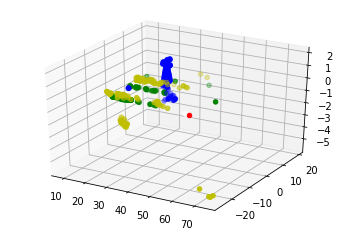

In [172]:
def test():
    # Now load dummy dataset
    pickle_outfile = os.path.join(os.getcwd(), "data", \
                                      "dataset_pc_labels_camera_start_{}_stop_{}.pkl".format(0, 3))

    with open(pickle_outfile, "rb") as f:
        A = pickle.load(f)
        f.close()

    keys = list(A.keys())
    for key in keys:
        CWD = os.getcwd()
        data_folder = os.path.join(CWD, "data","camera_lidar_semantic")
        ID_split = key.split("_")
        ID_split[-1] = ID_split[-1].split(".")[0]

        # Get paths for image, labels, and point clouds
        ind_data_dir = os.path.join(data_folder, ID_split[0][:-6]+"_"+ID_split[0][-6:])
        RGB = A[key]['rgb']
        ind_camera_dir = os.path.join(ind_data_dir, "camera", "cam_front_center")
        ind_pc_dir = os.path.join(ind_data_dir, "lidar", "cam_front_center")


        pc_file_name =  ID_split[0]+"_lidar_frontcenter_"+ID_split[1]+".npz"
        label_file_name = ID_split[0]+"_label_frontcenter_"+ID_split[1]+".png"
        camera_file_name = ID_split[0]+"_camera_frontcenter_"+ID_split[1]+".png"

        A_camera = cv.imread(os.path.join(ind_camera_dir, camera_file_name))
        pc = np.load(os.path.join(ind_pc_dir,pc_file_name), allow_pickle=True)

        # Give labels to points in PC equal to [row, index] these points map to in label image space
        keys = list(pc.keys())
        if 'row' in keys and 'col' in keys and 'points' in keys:
            rows, cols = pc['row'], pc['col']
            classes = []
            rgb = []
            N = len(rows)
            i = 0
            for row, col in zip(rows, cols): # O(n)
                i += 1


    # Get classes <--> labels dictionaries
    class_dict, rgb_dict = get_classes_to_ids()
    inverse_rgb_dict = {rgb_dict[key]:key for key in list(rgb_dict.keys())}

    test_id_consistency(A,1)
    # Now load dummy dataset
    pickle_outfile = os.path.join(os.getcwd(), "data", \
                                      "dataset_pc_labels_camera_start_{}_stop_{}.pkl".format(0, 3))

    with open(pickle_outfile, "rb") as f:
        A = pickle.load(f)
        f.close()

    keys = list(A.keys())
    for key in keys:
        print(A[key]['rgb'].shape)
        print(A[key]['labels'].shape)
        print(A[key]['points'].shape)

test()


## Create Dataset for Road Classification

In [200]:
# Make our dataset, as before
dataset = merge_data(start_index=0, stop_index=10000, combine_classes="road_detection")

FILES PICKLED
Number of IDs in dataset: 28652
START index is 0, STOP index is 10000
Iterated through 0 files
Iterated through 1000 files
Iterated through 2000 files
Iterated through 3000 files
Iterated through 4000 files
Iterated through 5000 files
Iterated through 6000 files
Iterated through 7000 files
Iterated through 8000 files
Iterated through 9000 files


## Test on Dataset To Ensure Proper Label Mapping

In [204]:
pkl_file = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_start_0_stop_10000_ROAD_DETECTION.pkl")
                        
with open(pkl_file, "rb") as f:
    D = pickle.load(f)
    f.close()
    

key = list(D.keys())[0]
print(np.max(D[key]['labels']))
print(np.min(D[key]['labels']))


1
0


In [205]:
import copy

pkl_file = os.path.join(os.getcwd(), "data", "dataset_pc_labels_camera_start_0_stop_10000_COMBINED_CLASSES.pkl")
with open(pkl_file, "rb") as f:
    D = pickle.load(f)
    f.close()

keys = list(D.keys())

# Now change the labels for each stage

# Stage 1
labels_map_stage_1 = {0: 0, 1: 0, 2: 0, 3: 3, 4: 0, 5: 0} 
labels_stage_1 = {} 
for key in keys:
    labels_stage_1[key] = []
    labels = D[key]['labels']
    for label in labels:
        labels_stage_1[key].append(labels_map_stage_1[label])
pkl_out_file_stage_1 = os.path.join(os.getcwd(), "data", "stage_1_labels.pkl")
# Now write new labels to output
with open(pkl_out_file_stage_1, "wb") as f:
    pickle.dump(labels_stage_1, f)
    f.close()
    
# Stage 2
labels_map_stage_2 = {0: 0, 1: 0, 2: 0, 3: 3, 4: 4, 5: 0}
labels_stage_2 = {} 
for key in keys:
    labels_stage_2[key] = []
    labels = D[key]['labels']
    for label in labels:
        labels_stage_2[key].append(labels_map_stage_2[label])
pkl_out_file_stage_2 = os.path.join(os.getcwd(), "data", "stage_2_labels.pkl")
# Now write new labels to output
with open(pkl_out_file_stage_2, "wb") as f:
    pickle.dump(labels_stage_2, f)
    f.close()
    
# Stage 3
labels_map_stage_3 = {0: 0, 1: 0, 2: 0, 3: 3, 4: 4, 5: 5}
labels_stage_3 = {} 
for key in keys:
    labels_stage_3[key] = []
    labels = D[key]['labels']
    for label in labels:
        labels_stage_3[key].append(labels_map_stage_3[label])
pkl_out_file_stage_3 = os.path.join(os.getcwd(), "data", "stage_3_labels.pkl")
# Now write new labels to output
with open(pkl_out_file_stage_3, "wb") as f:
    pickle.dump(labels_stage_3, f)
    f.close()

# Stage 4
labels_map_stage_4 = {0: 0, 1: 0, 2: 2, 3: 3, 4: 4, 5: 5}
labels_stage_4 = {} 
for key in keys:
    labels_stage_4[key] = []
    labels = D[key]['labels']
    for label in labels:
        labels_stage_4[key].append(labels_map_stage_4[label])
pkl_out_file_stage_4 = os.path.join(os.getcwd(), "data", "stage_4_labels.pkl")
# Now write new labels to output
with open(pkl_out_file_stage_4, "wb") as f:
    pickle.dump(labels_stage_4, f)
    f.close()
    
# Stage 5
labels_map_stage_5 = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}
labels_stage_5 = {} 
for key in keys:
    labels_stage_5[key] = []
    labels = D[key]['labels']
    for label in labels:
        labels_stage_5[key].append(labels_map_stage_5[label])
pkl_out_file_stage_5 = os.path.join(os.getcwd(), "data", "stage_5_labels.pkl")
# Now write new labels to output
with open(pkl_out_file_stage_5, "wb") as f:
    pickle.dump(labels_stage_5, f)
    f.close()

## Creating Different-Staged Datasets

## Creating .pkl files for classes

In [206]:
classes_combined = {0:"other", 1:"road", 2:"car", 3:"pedestrian", 4:"road signs/signals", 5:"lanes"}
pkl_out_file = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_COMBINED.pkl")
print(pkl_out_file)
with open(pkl_out_file, "wb") as f:
    pickle.dump(classes_combined, f)
    f.close()
    
classes_road_detection = {0:"non-road", 1:"road"}
pkl_out_file_road = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_ROAD_DETECTION.pkl")
with open(pkl_out_file_road, "wb") as f:
    pickle.dump(classes_road_detection, f)
    f.close()

# Write for Stage 1
classes_stage_1 = {0:"other", 3:"pedestrian"}
pkl_out_file_stage_1 = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_STAGE_1.pkl")
with open(pkl_out_file_stage_1, "wb") as f:
    pickle.dump(classes_stage_1, f)
    f.close()

# Write for Stage 2
classes_stage_2 = {0:"other", 3:"pedestrian", 4:"road signs/signals"}
pkl_out_file_stage_2 = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_STAGE_2.pkl")
with open(pkl_out_file_stage_2, "wb") as f:
    pickle.dump(classes_stage_2, f)
    f.close()

# Write for Stage 3
classes_stage_3 = {0:"other", 3:"pedestrian", 4:"road signs/signals", 5:"lanes"}
pkl_out_file_stage_3 = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_STAGE_3.pkl")
with open(pkl_out_file_stage_3, "wb") as f:
    pickle.dump(classes_stage_3, f)
    f.close()
    
# Write for Stage 4
classes_stage_4 = {0:"other", 3:"pedestrian", 4:"road signs/signals", 5:"lanes", 2:"car"}
pkl_out_file_stage_4 = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_STAGE_4.pkl")
with open(pkl_out_file_stage_4, "wb") as f:
    pickle.dump(classes_stage_4, f)
    f.close()
    
# Write for Stage 5
classes_stage_5 = {0:"other", 3:"pedestrian", 4:"road signs/signals", 5:"lanes", 2:"car", 1:"road"}
pkl_out_file_stage_5 = os.path.join(os.getcwd(), "data", "camera_lidar_semantic", "class_dictionary_STAGE_5.pkl")
with open(pkl_out_file_stage_5, "wb") as f:
    pickle.dump(classes_stage_5, f)
    f.close()

/home/ubuntu/869_final_project/point-cloud-transfer-learning/data/camera_lidar_semantic/class_dictionary_COMBINED.pkl


In [207]:
def show_point_cloud(tuple,seg_label=[],title=None):
    import matplotlib.pyplot as plt
    if seg_label == []:
        x = [x[0] for x in tuple]
        y = [y[1] for y in tuple]
        z = [z[2] for z in tuple]
        ax = plt.subplot(111, projection='3d')
        ax.scatter(x, y, z, c='b', cmap='spectral')
        ax.set_zlabel('Z')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
    else:
        category = list(np.unique(seg_label))
        color = ['b','r','g','y','w','b','p']
        ax = plt.subplot(111, projection='3d')
        for categ_index in range(len(category)):
            tuple_seg = tuple[seg_label == category[categ_index]]
            x = [x[0] for x in tuple_seg]
            y = [y[1] for y in tuple_seg]
            z = [z[2] for z in tuple_seg]
            ax.scatter(x, y, z, c=color[categ_index], cmap='spectral')
        ax.set_zlabel('Z')
        ax.set_ylabel('Y')
        ax.set_xlabel('X')
    plt.title(title)
    plt.show()